# Day 16

## part 1

- Start on `S` facing east and end on `E`
- moving adds 1 point
- rotating 90 degrees adds 1000 points
- lowest score wins

In [170]:
from copy import deepcopy
from dataclasses import dataclass
import logging

from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

from advent_of_code_utils.advent_of_code_utils import (
    parse_from_file, ParseConfig as PC, markdown, plot_str_grid, Point2 as P,
    plot_grid
)

log = logging.getLogger('day 16')
logging.basicConfig(level=logging.INFO)

INFO:advent_of_code_utils.py:141 items loaded from "day_16.txt"


INFO:advent_of_code_utils.py:converted 141x141 to ints


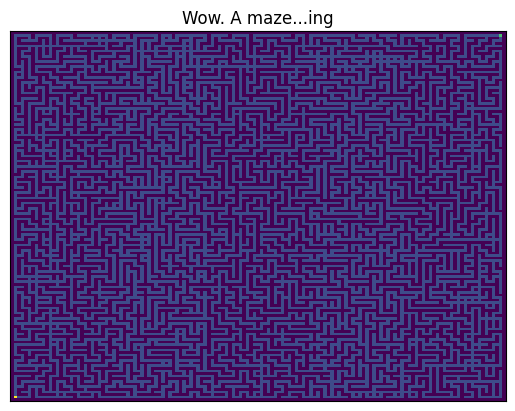

In [171]:
parser = PC('\n', PC('', str))
grid = parse_from_file('day_16.txt', parser)

fig, ax = plt.subplots()
ax.set_title('Wow. A maze...ing')
plot_str_grid(grid, ax)

In [172]:
def get_start_end(grid: list[list[str]]) -> tuple[P]:
    """returns the start and end points"""
    start, end = None, None
    for l, line in enumerate(grid):
        for c, char in enumerate(line):
            if char == 'S':
                start = P(l, c)
            elif char == 'E':
                end = P(l, c)
        if all((p is not None for p in (start, end))):
            log.info(f'{start=}, {end=}')
            return start, end
    else:
        raise ValueError(f'couldn\'t find start/end: {start=}, {end=}')

start, end = get_start_end(grid)

INFO:day 16:start=(139, 1), end=(1, 139)


In [173]:
@dataclass
class Dest:
    point: P
    facing: str
    cost: int

@dataclass
class Node:
    links: list[Dest]
    visited: bool = False
    score: int = None

    def __hash__(self) -> int:
        return hash((self.p, self.f))
    
    def __eq__(self, other: 'Node') -> bool:
        return all((self.p == other.p, self.f == other.f))

offsets = {
    'N': P(-1, 0),
    'E': P(0, 1),
    'S': P(1, 0),
    'W': P(0, -1),
}

cw = {'N': 'E', 'E': 'S', 'S': 'W', 'W': 'N'}
ccw = {value: key for key, value in cw.items()}

# ok next we're gonna need a graph
def get_graph(grid: list[list[str]]) -> list[list[Node | None]]:
    """returns a grid of movement possiblities / None if N/A"""
    # first find all possible nodes - i.e. all intersection points
    graph = [[None]*len(line) for line in grid]
    for l, line in enumerate(grid):
        for c, char in enumerate(line):
            # skip walls
            if char == '#':
                continue
            # find all neighbours
            point = P(l, c)
            neighbours = ''
            for adj, facing in zip(point.adjacent(), offsets):
                if grid[adj.l][adj.c] != '#':
                    neighbours += facing
            # any spaces with only a straight line available should be skipped
            if neighbours in ['EW', 'NS']:
                continue
            # else we have a node - add all possible directions to face
            graph[l][c] = {}
            for facing in offsets:
                links = \
                    [Dest(point, turn[facing], 1000) for turn in (cw, ccw)]
                graph[l][c].update({facing: Node(links)})

    log.info('created grid graph')

    # next find where each node goes and for how much
    for l, line in enumerate(graph):
        for c, directions in enumerate(line):
            if directions is None:
                continue
            tile = P(l, c)
            for direction, node in directions.items():
                # next find where facing that way will go
                point = tile + offsets[direction]
                steps = 1
                while graph[point.l][point.c] is None:
                    if grid[point.l][point.c] == '#':
                        point = None
                        break
                    point += offsets[direction]
                    steps += 1
                if point is not None:
                    node.links.append(Dest(point, direction, steps))
    log.info(f'grid graph links populated')
    return graph

graph = get_graph(grid)


INFO:day 16:created grid graph
INFO:day 16:grid graph links populated


In [174]:
def get_next_node(graph: dict[Node: list[Dest]]) -> Node | None:
    """returns the unvisited node with the lowest score or None if done"""
    lowest_node = None
    for l, line in enumerate(graph):
        for c, nodes in enumerate(line):
            if nodes is None:
                continue
            for node in nodes.values():
                # skip visited
                if node.visited:
                    continue
                # skip nodes that are not visitable yet
                if node.score is None:
                    continue
                if lowest_node is None:
                    lowest_node = node
                elif node.score < lowest_node.score:
                    lowest_node = node
    return lowest_node

def update_scores(
        graph: dict[Node: list[Dest]], start: P, end: P = None) -> None:
    """updates the scores navigating from start to end"""
    graph[start.l][start.c]['E'].score = 0
    while True:
        # find an unvisited node with the least score
        node = get_next_node(graph)
        if node is None:
            log.error('tested all reachable node without getting to the end!')
            return
        print(f'{node.score=}', end='\r')

        for dest in node.links:
            dest_node = graph[dest.point.l][dest.point.c][dest.facing]
            if dest_node.visited:
                continue
            new_score = node.score + dest.cost
            if dest_node.score is None:
                dest_node.score = new_score
            elif new_score < dest_node.score:
                dest_node.score = new_score
            # else the destination was closer than via this node

            # if we did get to the end, break!
            if end is not None:
                if dest.point == end:
                    log.info('Reached the end!')
                    return

        node.visited = True


In [175]:
update_scores(graph, start, end)

INFO:day 16:Reached the end!


In [176]:
end_nodes = graph[end.l][end.c].values()
min_score = min((node.score for node in end_nodes if node.score is not None))

markdown(
    f'The minimum score for the maze is {min_score}'
)

The minimum score for the maze is 106512

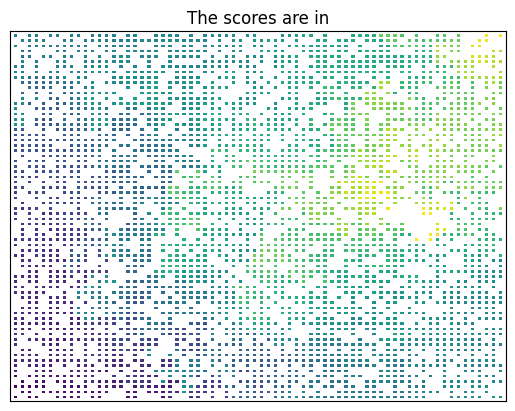

In [177]:
def plot_graph(graph: list[list[dict[Node]]], ax: plt.Axes) -> None:
    temp = []
    for line in graph:
        temp.append([])
        for nodes in line:
            if nodes is None:
                temp[-1].append(np.nan)
                continue
            scores = [
                node.score for node in nodes.values()
                if node.score is not None
            ]
            if len(scores) == 0:
                temp[-1].append(np.nan)
            else:
                temp[-1].append(min(scores))

    plot_grid(temp, ax)


fig, ax = plt.subplots()
ax.set_title('The scores are in')
plot_graph(graph, ax)

## part 2

- count the number of tiles which are part of the best paths through the maze

In [178]:
# lets just make sure all points are explored
# i updated this function so it doesn't need an end point to be specified
# if not specified it will just try all nodes until it can't get to any more
update_scores(graph, start)

ERROR:day 16:tested all reachable node without getting to the end!


In [179]:
def find_path(
    point: P, offset: P, graph: list[list[dict]], grid: list[list[str]]
) -> list[P] | None:
    """
    returns a list of points between the point and the next node or None if
    none found
    """
    path = [point]
    current = point + offset
    while graph[current.l][current.c] is None:
        if grid[current.l][current.c] == '#':
            return None
        # add current point
        path.append(current)
        current += offset
        # bounds check - if fails the path is not valid - return None
        if not (
            0 <= current.l < len(graph) and
            0 <= current.c < len(graph[0])
        ):
            return None
    path.append(current)
    return path

def find_score(route: list[P]) -> int:
    """returns the score of this route"""
    score = 0
    if len(route) < 2:
        return len(route) - 1
    direction = route[1] - route[0]
    next_point = route[1] + direction
    score += 1
    for point in route[2:]:
        # if still going the same way
        if next_point == point:
            score += 1
            next_point = point + direction
        # else find which way we turned and go that way
        else:
            score += 1001
            previous = (next_point - direction)
            direction = point - previous
            next_point = point + direction
    return score

def get_routes(
    graph: list[list[dict]], grid: list[list[str]], start: P, end: P
) -> list[list[P]]:
    """returns the points along which the optimal routes go"""
    # first let's condense the graph down to just the min score at each node
    score_grid = []
    for line in graph:
        score_grid.append([])
        for nodes in line:
            if nodes is None:
                score_grid[-1].append(None)
                continue
            scores = [
                node.score for node in nodes.values()
                if node.score is not None
            ]
            if len(scores) == 0:
                score_grid[-1].append(None)
            else:
                score_grid[-1].append(min(scores))

    # now trace back the minimum path nodes
    valid_branches = []
    routes = [[end]]
    # iterate until start found
    while not all((route[-1] == start for route in routes)):
        # print(f'{len(routes)=}', end='\r')
        # now review where we can go from each head
        # log.debug('testing routes again')
        temp_routes = []
        for route in routes:
            head = route[-1]
            # log.debug(f'testing {head=}')
            if head == start:
                continue
            paths = []
            # look in all directions from each head point
            for offset in offsets.values():
                # get the path in that direction
                paths.append(find_path(head, offset, graph, grid))
            # find any paths that have a lower score
            ok_paths = []
            head_score = score_grid[head.l][head.c]
            for path in paths:
                if path is None:
                    continue
                score = score_grid[path[-1].l][path[-1].c]
                if score is None:
                    continue
                if score < head_score:
                    ok_paths.append(path)
            
            # create new copies of the route with the ok paths appended
            for path in ok_paths:
                new_route = deepcopy(route) + path[1:]
                temp_routes.append(new_route)
        routes = []
        # check routes against each other to make sure they're ok to continue
        for route in temp_routes:
            to_pop = []
            head = route[-2]
            for index, other in enumerate(routes):
                # skip if head not in other route
                if head not in other:
                    continue
                # if the head of this route is in the other
                score = find_score(route)
                other_score = \
                    find_score(other[:other.index(head) + 2])
                # if this route is worse, break to skip appending it
                log.debug(f'{score=}, {other_score=}')
                if score > other_score:
                    log.debug(f'better route already {len(route)=}')
                    break
                # if the routes match, add this one to complete and skip
                if score == other_score:
                    log.debug(f'matching score found to {len(route)=}')
                    valid_branches.append(route)
                    break
                # if this route is actually better than the other
                # note down the other's index for later for removal
                # and continue so this one gets added
                if score < other_score:
                    log.debug(f'this route is better {len(route)=}')
                    to_pop.append(index)
            # if we get here without breaking, append the route for next time
            else:
                # log.debug(f'added route at {head}')
                routes.append(route)
            # remove routes that were worse
            for index in reversed(to_pop):
                log.debug(f'removing {index=}')
                routes.pop(index)
    log.debug(f'{len(routes)=}')
    routes += valid_branches
    log.info('reached start')
    return routes

log.setLevel(logging.DEBUG)
routes = get_routes(graph, grid, start, end)

DEBUG:day 16:score=25098, other_score=27098
DEBUG:day 16:this route is better len(route)=99
DEBUG:day 16:removing index=0
DEBUG:day 16:score=42148, other_score=42148
DEBUG:day 16:matching score found to len(route)=149
DEBUG:day 16:score=42150, other_score=42150
DEBUG:day 16:matching score found to len(route)=151
DEBUG:day 16:score=42152, other_score=42152
DEBUG:day 16:matching score found to len(route)=153
DEBUG:day 16:score=42154, other_score=42154
DEBUG:day 16:matching score found to len(route)=155
DEBUG:day 16:score=43172, other_score=43168
DEBUG:day 16:better route already len(route)=173
DEBUG:day 16:score=57238, other_score=59238
DEBUG:day 16:this route is better len(route)=239
DEBUG:day 16:removing index=0
DEBUG:day 16:score=58242, other_score=58242
DEBUG:day 16:matching score found to len(route)=243
DEBUG:day 16:score=60244, other_score=58244
DEBUG:day 16:better route already len(route)=245
DEBUG:day 16:score=62274, other_score=62274
DEBUG:day 16:matching score found to len(rout

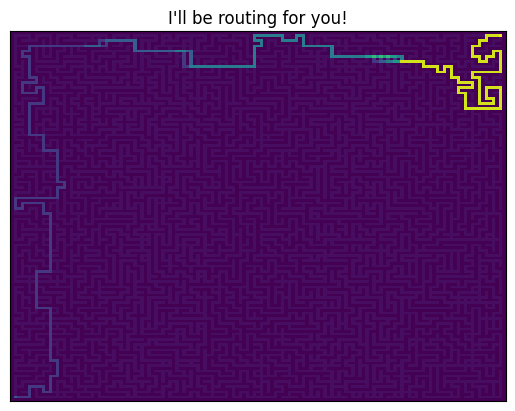

In [197]:
def plot_routes(routes: list[list[P]], grid: list[list[str]], ax: plt.Axes) -> None:
    """highlights the route tiles the grid"""
    temp = [[ord(char) for char in line] for line in grid]
    for route in routes:
        for point in route:
            temp[point.l][point.c] += 300 / len(routes)
    plot_grid(temp, ax)

fig, ax = plt.subplots()
ax.set_title('I\'ll be routing for you!')
plot_routes(routes, grid, ax)

In [196]:
log.info(f'{max([len(route) for route in routes])=}')
for route in routes:
    log.info(f'{len(route)=}')
tile_set = set()
# generate a set of all route tiles
for route in routes:
    tile_set = tile_set.union(set(route))
log.info(f'{(start in tile_set)=}')
log.info(f'{(end in tile_set)=}')

INFO:day 16:max([len(route) for route in routes])=513
INFO:day 16:len(route)=513
INFO:day 16:len(route)=149
INFO:day 16:len(route)=151
INFO:day 16:len(route)=153
INFO:day 16:len(route)=155
INFO:day 16:len(route)=243
INFO:day 16:len(route)=275
INFO:day 16:(start in tile_set)=True
INFO:day 16:(end in tile_set)=True


In [195]:
markdown(f'The number of route tiles is {len(tile_set)}')

The number of route tiles is 535

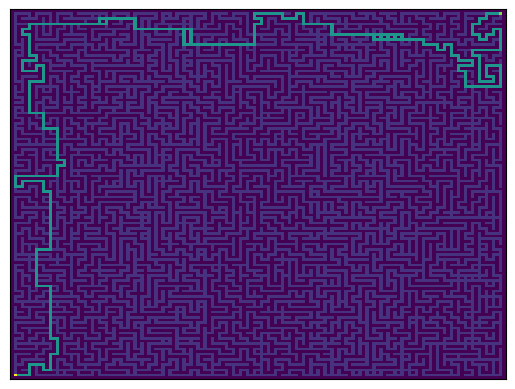

In [194]:
fig, ax = plt.subplots()
plot_routes([tile_set], grid, ax)

INFO:day 16:len(route)=513, 106512
INFO:day 16:len(route)=149, 42148
INFO:day 16:len(route)=151, 42150
INFO:day 16:len(route)=153, 42152
INFO:day 16:len(route)=155, 42154
INFO:day 16:len(route)=243, 58242
INFO:day 16:len(route)=275, 62274


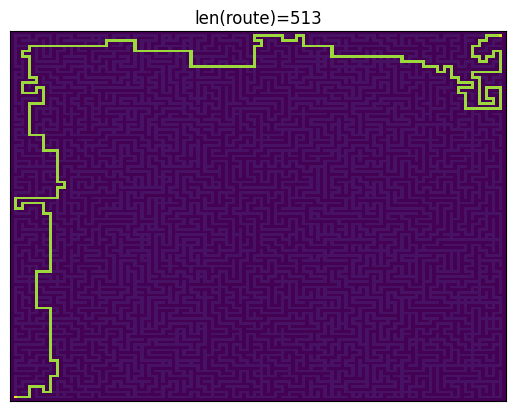

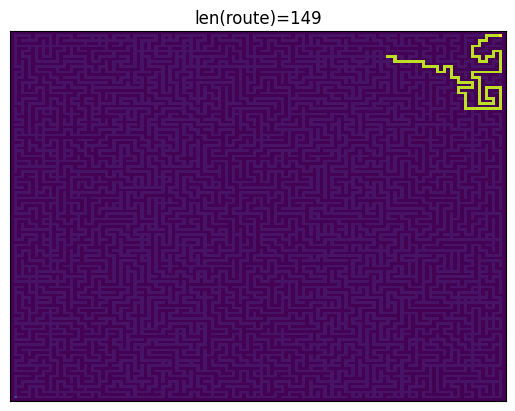

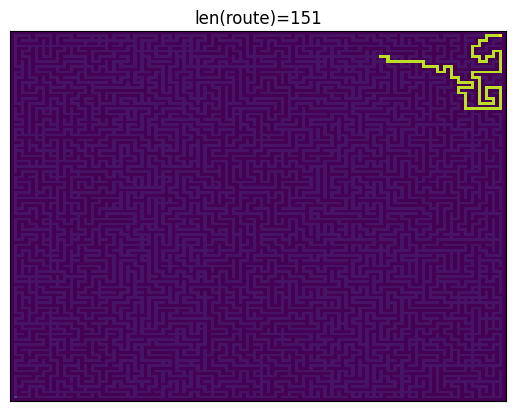

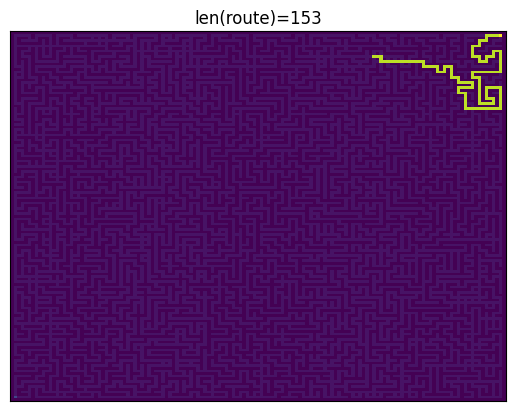

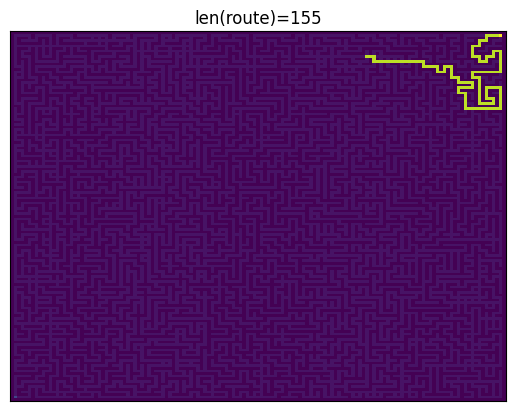

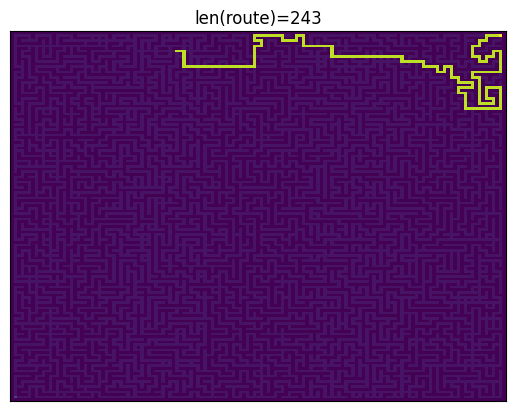

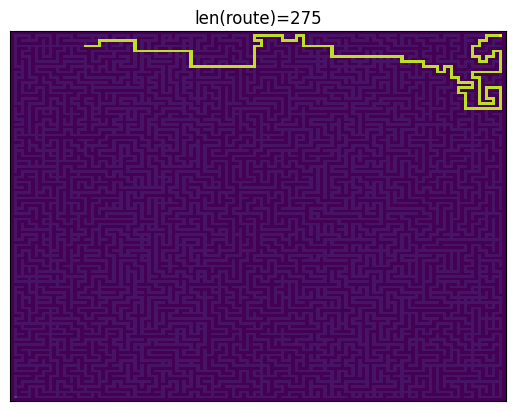

In [188]:
for route in routes:
    fig, ax = plt.subplots()
    ax.set_title(f'{len(route)=}')
    plot_routes([route], grid, ax)
    log.info(f'{len(route)=}, {find_score(route)}')